<a href="https://colab.research.google.com/github/KLAU-S/SRIP2022/blob/main/Q3alt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

## Hyperparameters

In [12]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

## Auto-batching predictions

Defining prediction function, we will use JAX's `vmap` function to automatically handle mini-batches, with no performance penalty.

In [13]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

In [14]:
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))

In [15]:
# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(10, 10)


We've built an auto-batched version of `predict`, which we should be able to use in a loss function. We should be able to use `grad` to take the derivative of the loss with respect to the neural network parameters. Last, we should be able to use `jit` to speed up everything.

## Utility and loss functions

In [16]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

## Data Loading with `tensorflow`

In [17]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

In [18]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)

Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


## Training Loop

In [32]:
import time
test_acc_list = []
train_acc_list = []

def get_train_batches():
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir=data_dir)
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in get_train_batches():
    x = jnp.reshape(x, (len(x), num_pixels))
    y = one_hot(y, num_labels)
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 8.29 sec
Training set accuracy 0.9922000169754028
Test set accuracy 0.9768999814987183
Epoch 1 in 7.89 sec
Training set accuracy 0.9926666617393494
Test set accuracy 0.9767999649047852
Epoch 2 in 8.15 sec
Training set accuracy 0.9933333396911621
Test set accuracy 0.9770999550819397
Epoch 3 in 8.36 sec
Training set accuracy 0.9940000176429749
Test set accuracy 0.9770999550819397
Epoch 4 in 8.40 sec
Training set accuracy 0.9945499897003174
Test set accuracy 0.9770999550819397
Epoch 5 in 8.35 sec
Training set accuracy 0.994949996471405
Test set accuracy 0.9772999882698059
Epoch 6 in 8.41 sec
Training set accuracy 0.9951500296592712
Test set accuracy 0.977899968624115
Epoch 7 in 9.22 sec
Training set accuracy 0.9955000281333923
Test set accuracy 0.9781000018119812
Epoch 8 in 8.15 sec
Training set accuracy 0.9958500266075134
Test set accuracy 0.9782999753952026
Epoch 9 in 8.60 sec
Training set accuracy 0.9963499903678894
Test set accuracy 0.9782999753952026


In [44]:
import numpy as np
np.array(train_acc_list)

[DeviceArray(0.9922, dtype=float32),
 DeviceArray(0.99266666, dtype=float32),
 DeviceArray(0.99333334, dtype=float32),
 DeviceArray(0.994, dtype=float32),
 DeviceArray(0.99455, dtype=float32),
 DeviceArray(0.99495, dtype=float32),
 DeviceArray(0.99515, dtype=float32),
 DeviceArray(0.9955, dtype=float32),
 DeviceArray(0.99585, dtype=float32),
 DeviceArray(0.99635, dtype=float32)]

Text(0, 0.5, 'Testing Accuracy')

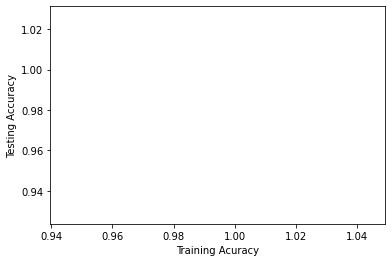

In [33]:
from functools import reduce
import matplotlib.pyplot as plt
  
def Average(lst):
    return reduce(lambda a, b: a + b, lst) / len(lst)
  
average = Average(train_acc_list)
average2 = Average(test_acc_list)

%matplotlib inline

# plot the relationship between K and testing accuracy
plt.plot(average, average2)
plt.xlabel('Training Acuracy')
plt.ylabel('Testing Accuracy')


Text(0, 0.5, 'Testing Accuracy')

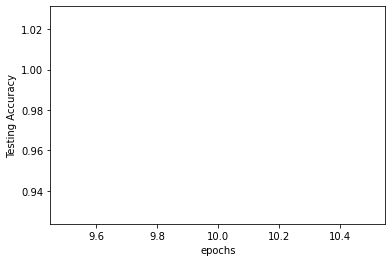

In [34]:
%matplotlib inline

# plot the relationship between K and testing accuracy
plt.plot(num_epochs, average2)
plt.xlabel('epochs')
plt.ylabel('Testing Accuracy')